In [14]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm
import matplotlib.colors
import cmocean
from matplotlib.gridspec import GridSpec

### Trying to plot a random set of arrows in matplotlib

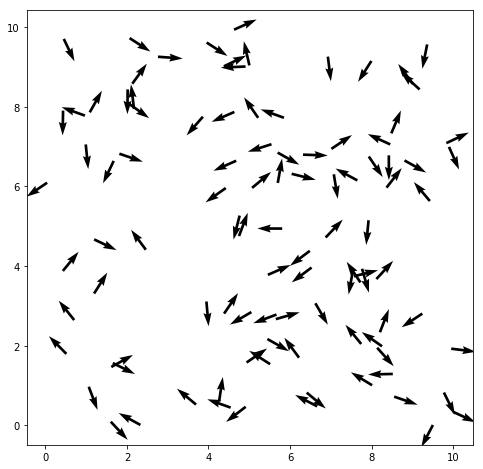

In [2]:
dx = 1
dy = 1
L = 10

plt.figure(figsize=(8,8))
x, y, dx, dy = np.zeros(100), np.zeros(100), np.zeros(100), np.zeros(100)
for i in range(100):
    x[i], y[i] = 10*rnd.random(), 10*rnd.random()
    dx[i], dy[i] = 2*(rnd.random()-0.5), 2*(rnd.random()-0.5)
    dr = np.sqrt(dx[i]**2 + dy[i]**2)
    dx[i] *= 1/dr
    dy[i] *= 1/dr
plt.quiver(x, y, dx, dy)
plt.show()

---

In [35]:
class Configuration(object):
    def __init__(self, L, N, eta, dt):  # , v, r):
        self.size = L
        self.N = N
        self.pos = rnd.rand(N, 2) * L
        self.v = 1
        self.theta = rnd.rand(N) * 2 * np.pi
        self.eta = eta
        self.dt = dt
        self.r = 0.3  # radius within which the particles interact with each other
        
    def get_avg_speed(self):
        x_mean, y_mean = np.mean(np.cos(self.theta)), np.mean(np.sin(self.theta))
        return np.sqrt(np.dot(x_mean, x_mean)**2 + np.dot(y_mean, y_mean)**2) * self.v
    
    def get_energy(self):
        # ...
        return e
    
    def get_magnetization(self):
        # ...
        return m

### Metropolis move

In [16]:
def move(config):
    """Modify (or not) a configuration with Metropolis algorithm"""

    L = config.size
    N = config.N
    r = config.r
    v = config.v
    dt = config.dt
    eta = config.eta

    for i in range(N):
        lst_close = []
        for j in range(N):
            distance = np.linalg.norm(config.pos[i]-config.pos[j])
            if distance < r:
                lst_close.append(j)
        median_theta = 0
        for close in lst_close:
            median_theta += config.theta[close]
        median_theta = median_theta / len(lst_close)
        delta_theta = eta * rnd.random()
        config.theta[i] = (median_theta + delta_theta) % (2*np.pi)
        
        # Verlet movement *after* updating directions
        config.pos[i] = (config.pos[i] + v * np.array([np.cos(config.theta[i]), np.sin(config.theta[i])]) * dt) % L  # update position of particle i


#### Plot

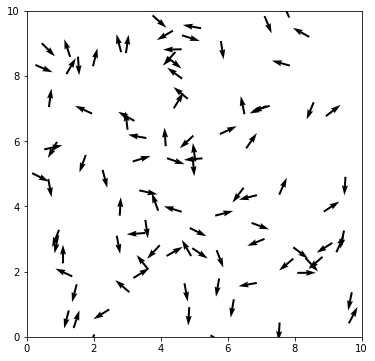

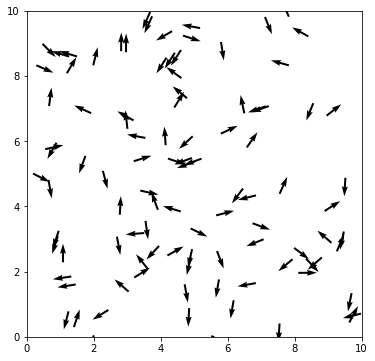

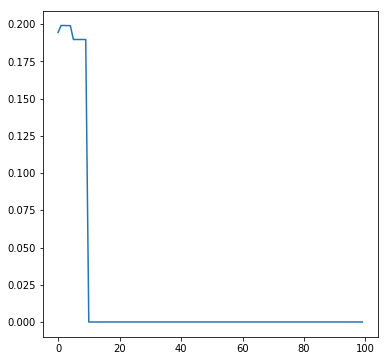

In [ ]:
L = 10
N = 100
eta = 0.00
dt = 0.003

config = Configuration(L, N, eta, dt)

plt.figure(figsize=(6, 6))
plt.quiver(config.pos[:,0], config.pos[:,1], np.cos(config.theta), np.sin(config.theta))
plt.xlim(0, L)
plt.ylim(0, L)

avg_speed = np.zeros(100)
for i in range(10):
    move(config)
    avg_speed[i] = config.get_avg_speed()
    # plt.figure(figsize=(6,6))
    # plt.quiver(config.x,config.y, np.cos(config.theta), np.sin(config.theta))

plt.figure(figsize=(6, 6))
plt.quiver(config.pos[:,0], config.pos[:,1], np.cos(config.theta), np.sin(config.theta))
plt.xlim(0, L)
plt.ylim(0, L)

plt.figure(figsize=(6, 6))
plt.plot([i for i in range(100)], avg_speed)

plt.show()


In [17]:
#### Animation

In [54]:

L = 10
N = 200
eta = 0.02 * np.pi
dt = 0.03
total_time = 5

config = Configuration(L, N, eta, dt)

X, Y = config.pos[:,0], config.pos[:,1]
U = np.cos(config.theta)
V = np.sin(config.theta)

Writer = animation.writers['ffmpeg']  # to save video
writer = Writer(fps=15, bitrate=-1)  # to save video

gs = GridSpec(2, 2)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
fig.set_size_inches(10, 10, True)

time_text = ax1.text(0.02, 0.95, '', transform=ax1.transAxes)

norm = matplotlib.colors.Normalize(vmin=0, vmax=2*np.pi)
cm = cmocean.cm.phase
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm); sm.set_array([])
# fig.colorbar(sm)

avg_speed, = ax2.plot([], [], lw=2)

Q = ax1.quiver(X, Y, U, V, cmap=cm)

ax1.set_xlim(0, L)
ax1.set_ylim(0, L)
ax2.set_xlim(0, total_time)
ax2.set_ylim(0, config.v/2)
ax2.set_xlabel("time (s)")
ax2.set_ylabel("avg. speed (m/s)")

avg_speeds = []
timestamps = np.arange(0, total_time, dt)


def update_quiver(num, Q, time_text, avg_speed):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """
    move(config)

    X, Y = config.pos[:,0], config.pos[:,1]
    new_offsets = np.zeros((config.N, 2))
    for i in range(N):
        new_offsets[i][0] = X[i]
        new_offsets[i][1] = Y[i]
    U = np.cos(config.theta)
    V = np.sin(config.theta)
    Q.set_offsets(new_offsets)
    Q.set_UVC(U, V, norm(config.theta))
    Q.color = cm(norm(config.theta))
    avg_speeds.append(config.get_avg_speed())
    avg_speed.set_data(timestamps[:num+1], avg_speeds[:num+1])
    
    time_text.set_text('time = %.1f s' % round(dt * num, 3))

    return Q, time_text, avg_speed


anim = animation.FuncAnimation(fig, update_quiver, frames=int(total_time/dt), fargs=(Q, time_text, avg_speed),
                               interval=200, blit=False)
anim.save('lines.mp4', writer=writer)

plt.show()
